**Author**: _Pradip Kumar Das_

**License:** https://github.com/PradipKumarDas/Competitions/blob/main/LICENSE

**Profile & Contact:** [LinkedIn](https://www.linkedin.com/in/daspradipkumar/) | [GitHub](https://github.com/PradipKumarDas) | [Kaggle](https://www.kaggle.com/pradipkumardas) | pradipkumardas@hotmail.com (Email)

# Tabular Playground Series - Jan. 2022

**Jan 01, 2022 to Jan 31, 2022**

https://www.kaggle.com/c/tabular-playground-series-jan-2022/

_**Forecasting product sales for multiple chain stores.**_

**Sections:**
- Dependencies
- Exploratory Data Analysis (EDA) & Preprocessing
- Modeling & Evaluation
- Submission

# Dependencies

In [1]:
# Loads required packages

import numpy as np
import pandas as pd

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape

import matplotlib.pyplot as plt
import seaborn as sns

# Exploratory Data Analysis (EDA) & Preprocessing

In [2]:
# Configures styles for its runtime

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

# %matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Helper functions to draw seasonal plots and periodograms (source: https://www.kaggle.com/ryanholbrook/seasonality)

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


In [24]:
# Loads train dataset
train = pd.read_csv("./data/train.csv", parse_dates=["date"])

In [25]:
# Checks how the train data set looks
display(train)

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911
...,...,...,...,...,...,...
26293,26293,2018-12-31,Sweden,KaggleMart,Kaggle Hat,823
26294,26294,2018-12-31,Sweden,KaggleMart,Kaggle Sticker,250
26295,26295,2018-12-31,Sweden,KaggleRama,Kaggle Mug,1004
26296,26296,2018-12-31,Sweden,KaggleRama,Kaggle Hat,1441


In [26]:
# Drops the "row_id" column considering it not required
train.drop(["row_id"], axis=1, inplace=True)

In [27]:
# Shows the summary of the train data set
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      26298 non-null  datetime64[ns]
 1   country   26298 non-null  object        
 2   store     26298 non-null  object        
 3   product   26298 non-null  object        
 4   num_sold  26298 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.0+ MB


In [28]:
# Converts 'date' column to period with 'day' frequency
train.date = train.date.dt.to_period("D")

In [29]:
# Reindexes train data set with sorting
train = train.set_index(["country", "store", "product", "date"]).sort_index()

In [30]:
# Checks how the data looks like
display(train)

num_sold
country store      product        date                
Finland KaggleMart Kaggle Hat     2015-01-01       520
                                  2015-01-02       493
                                  2015-01-03       535
                                  2015-01-04       544
                                  2015-01-05       378
...                                                ...
Sweden  KaggleRama Kaggle Sticker 2018-12-27       319
                                  2018-12-28       441
                                  2018-12-29       596
                                  2018-12-30       587
                                  2018-12-31       388

[26298 rows x 1 columns]

<AxesSubplot:xlabel='date'>

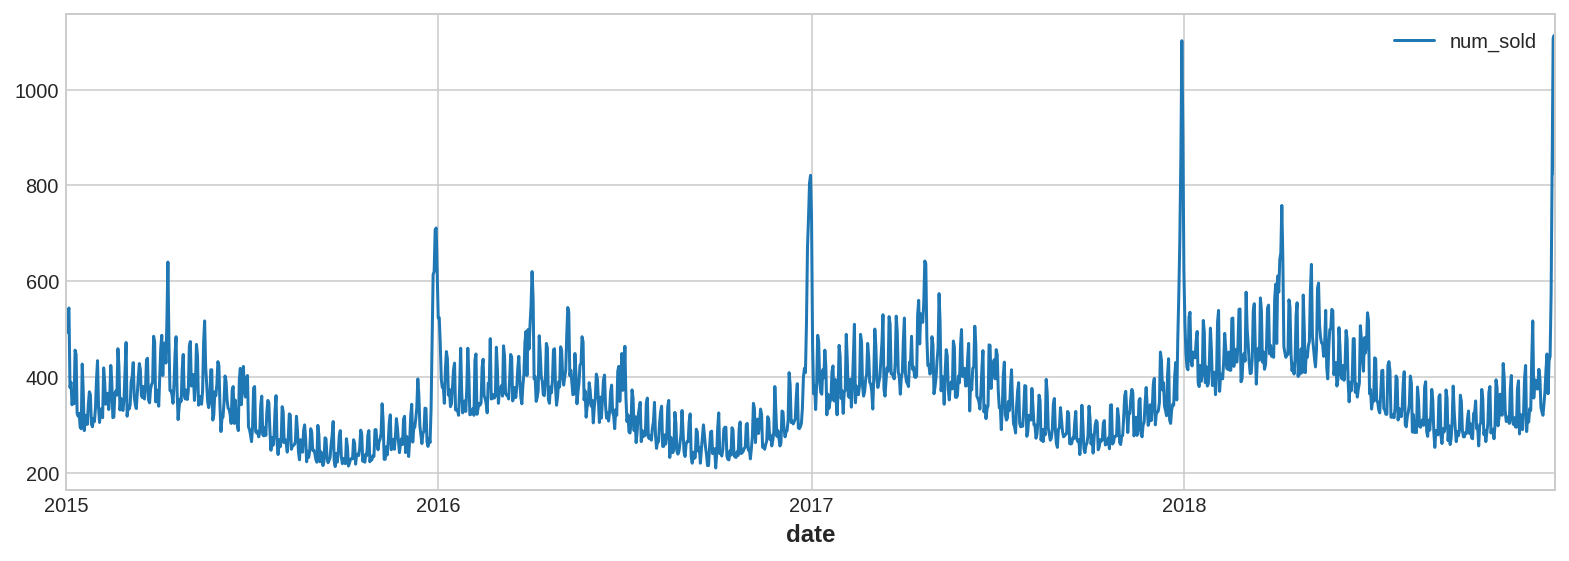

In [31]:
# Checks how the sales for a product in store looks like
train.loc['Finland', 'KaggleMart', 'Kaggle Hat'].plot()

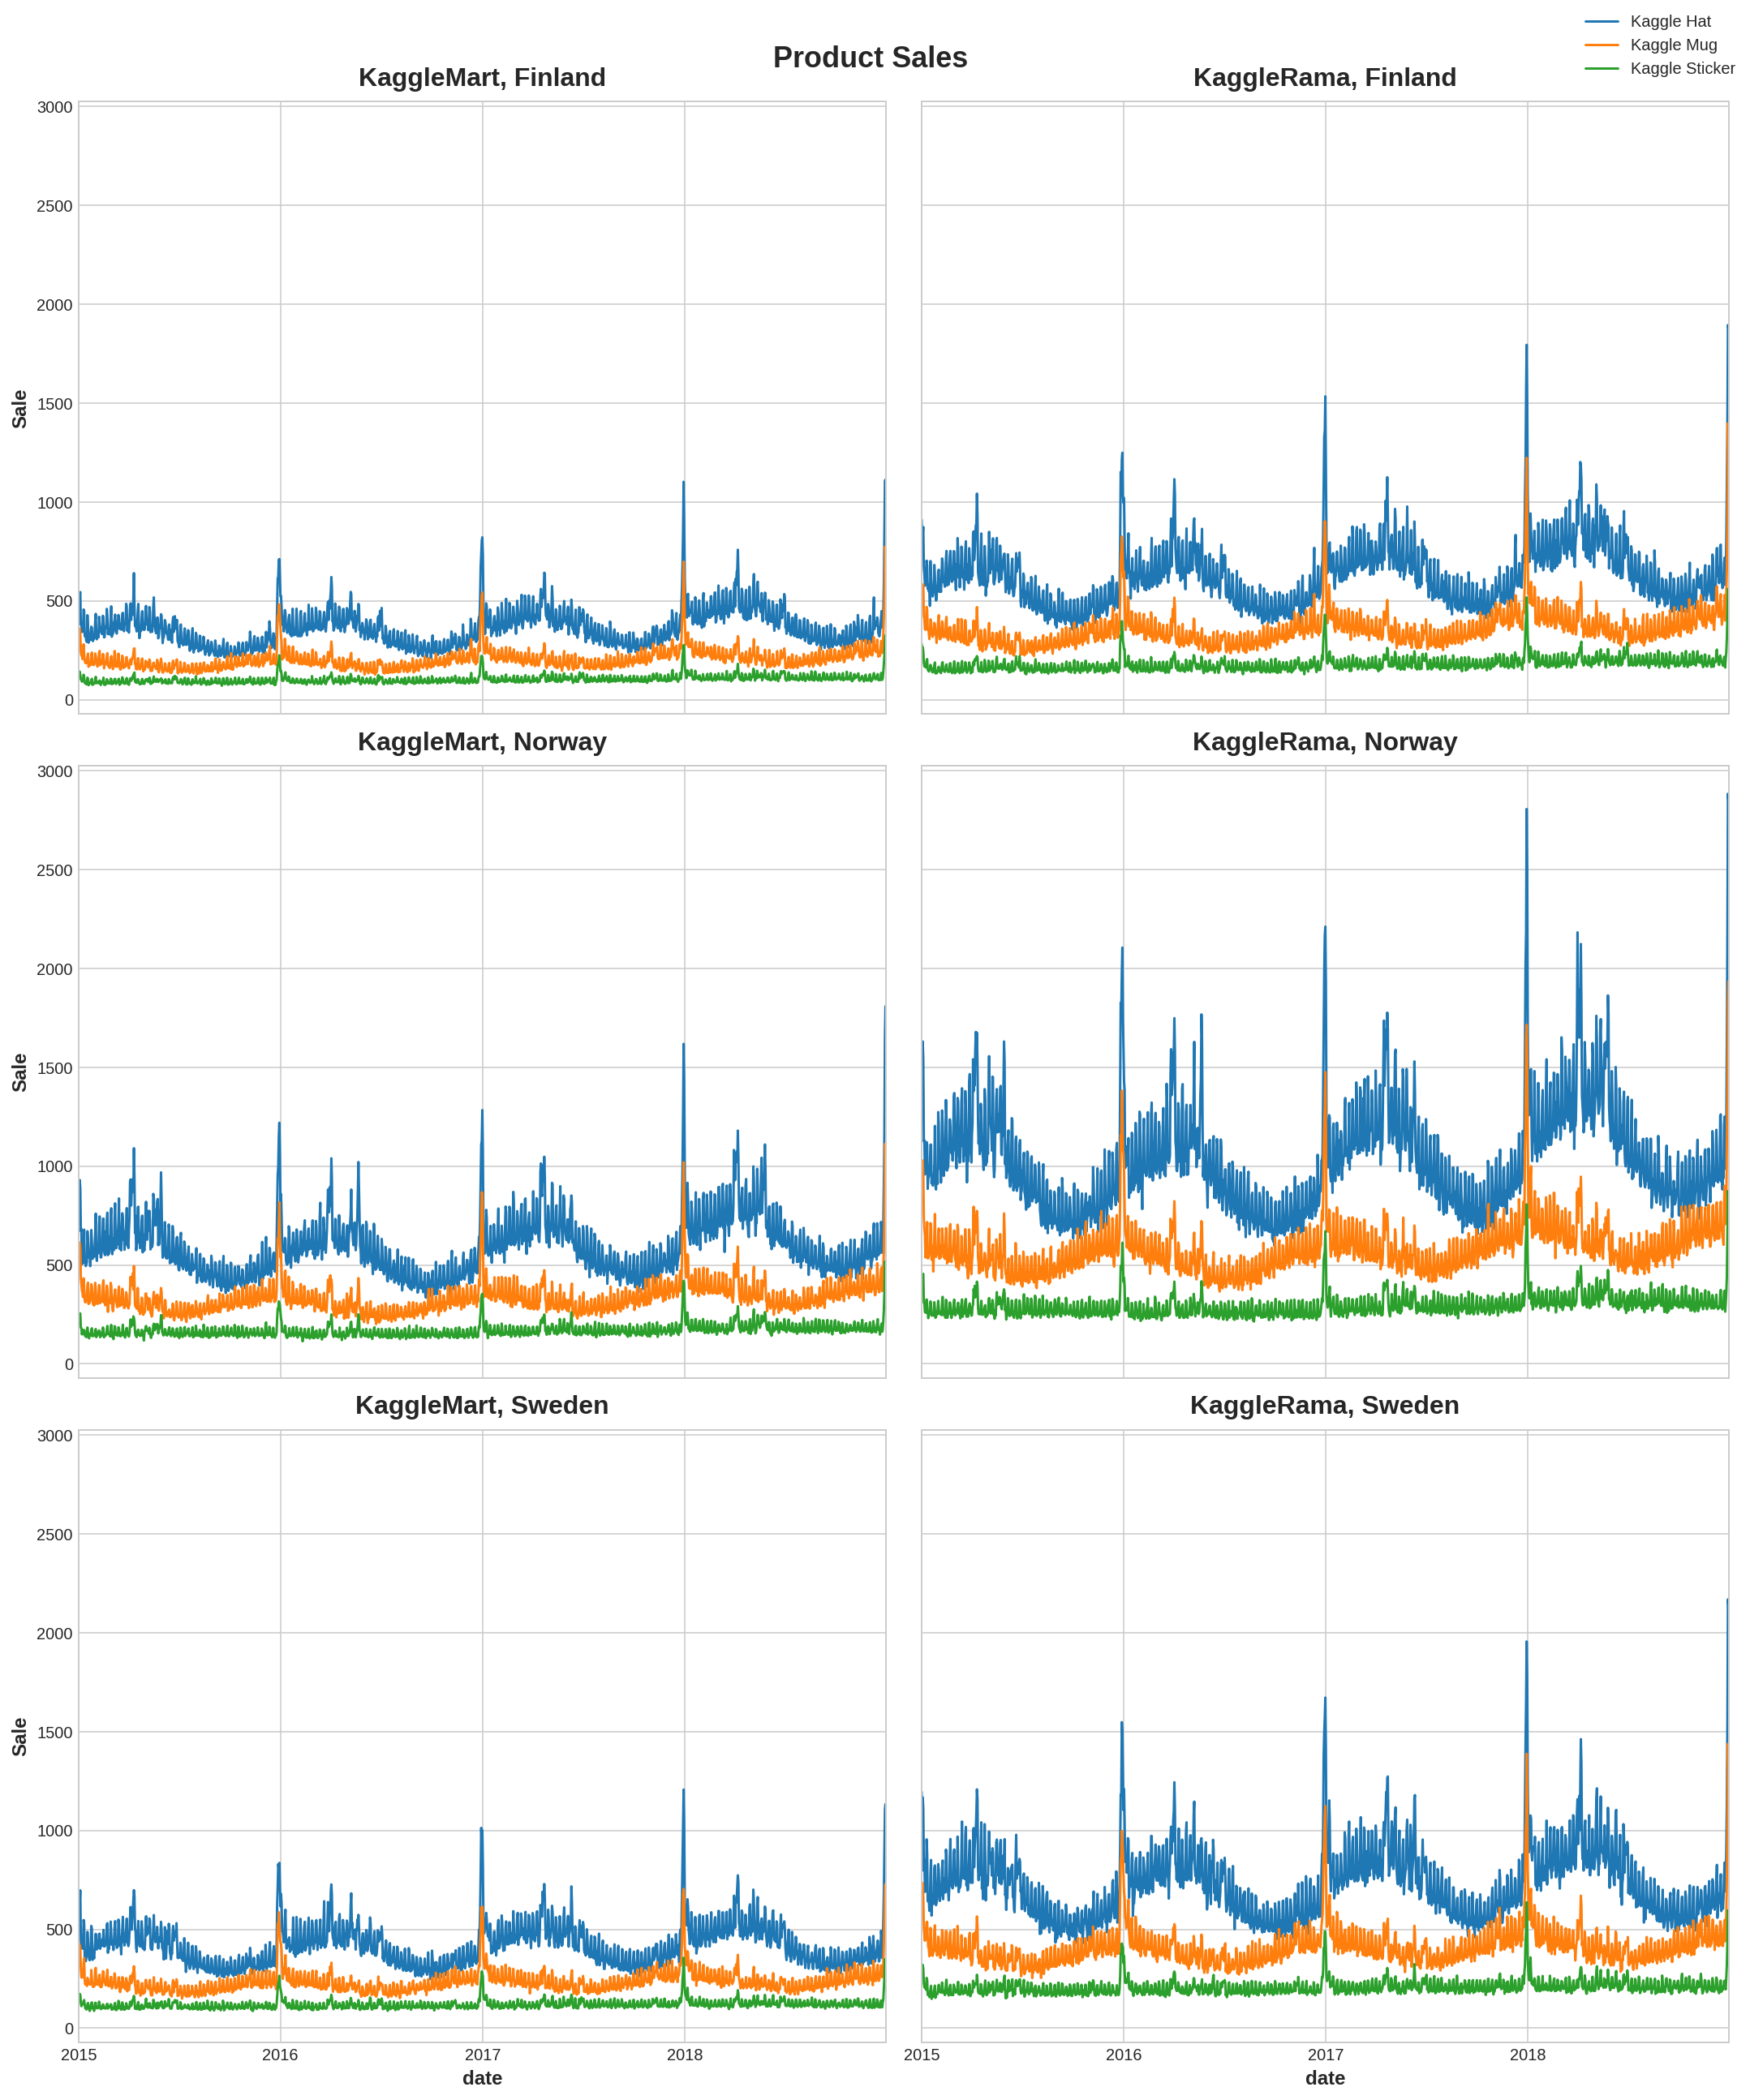

In [35]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(15, 18))

fig.suptitle("Product Sales")

train.loc['Finland','KaggleMart','Kaggle Hat'].plot(ax=axs[0,0], ylabel="Sale", title="KaggleMart, Finland")
train.loc['Finland','KaggleMart','Kaggle Mug'].plot(ax=axs[0,0])
train.loc['Finland','KaggleMart','Kaggle Sticker'].plot(ax=axs[0,0])
axs[0,0].legend([])

train.loc['Finland','KaggleRama','Kaggle Hat'].plot(ax=axs[0,1], title="KaggleRama, Finland")
train.loc['Finland','KaggleRama','Kaggle Mug'].plot(ax=axs[0,1])
train.loc['Finland','KaggleRama','Kaggle Sticker'].plot(ax=axs[0,1])
axs[0,1].legend([])

train.loc['Norway','KaggleMart','Kaggle Hat'].plot(ax=axs[1,0], ylabel="Sale", title="KaggleMart, Norway")
train.loc['Norway','KaggleMart','Kaggle Mug'].plot(ax=axs[1,0])
train.loc['Norway','KaggleMart','Kaggle Sticker'].plot(ax=axs[1,0])
axs[1,0].legend([])

train.loc['Norway','KaggleRama','Kaggle Hat'].plot(ax=axs[1,1], title="KaggleRama, Norway")
train.loc['Norway','KaggleRama','Kaggle Mug'].plot(ax=axs[1,1])
train.loc['Norway','KaggleRama','Kaggle Sticker'].plot(ax=axs[1,1])
axs[1,1].legend([])

train.loc['Sweden','KaggleMart','Kaggle Hat'].plot(ax=axs[2,0], ylabel="Sale", title="KaggleMart, Sweden")
train.loc['Sweden','KaggleMart','Kaggle Mug'].plot(ax=axs[2,0])
train.loc['Sweden','KaggleMart','Kaggle Sticker'].plot(ax=axs[2,0])
axs[2,0].legend([])

train.loc['Sweden','KaggleRama','Kaggle Hat'].plot(ax=axs[2,1], title="KaggleRama, Sweden")
train.loc['Sweden','KaggleRama','Kaggle Mug'].plot(ax=axs[2,1])
train.loc['Sweden','KaggleRama','Kaggle Sticker'].plot(ax=axs[2,1])
axs[2,1].legend([])

fig.legend(
    ["Kaggle Hat", "Kaggle Mug", "Kaggle Sticker"])

**Initial observations from the above plots:**
- Sale at KaggleRama is more than the sale at KaggleMart across countries
- Annual seasonlality with multiple short frequencies in each month was observed especially for product "Kaggle Hut" and "Kaggle Mug"
- Prominent spikes especially at end of year were observed.
- No major trend was observed

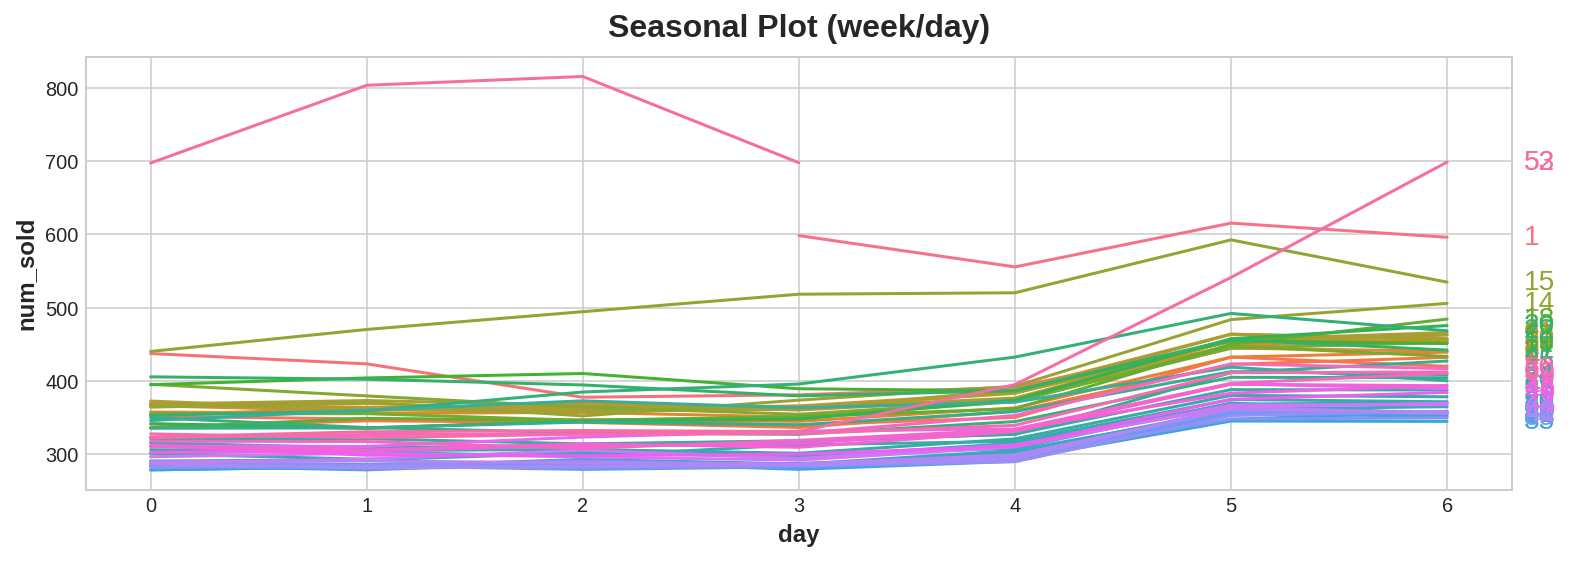

In [43]:
# Checks how day of a week affect sales by ploting 2015's average sales

average_sales = train.groupby("date").mean()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='num_sold', period='week', freq='day');

The above plot shows that sales increaes over weekends confirming weekly seasonality

/home/pradip/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  after removing the cwd from sys.path.
/home/pradip/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  """
/home/pradip/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

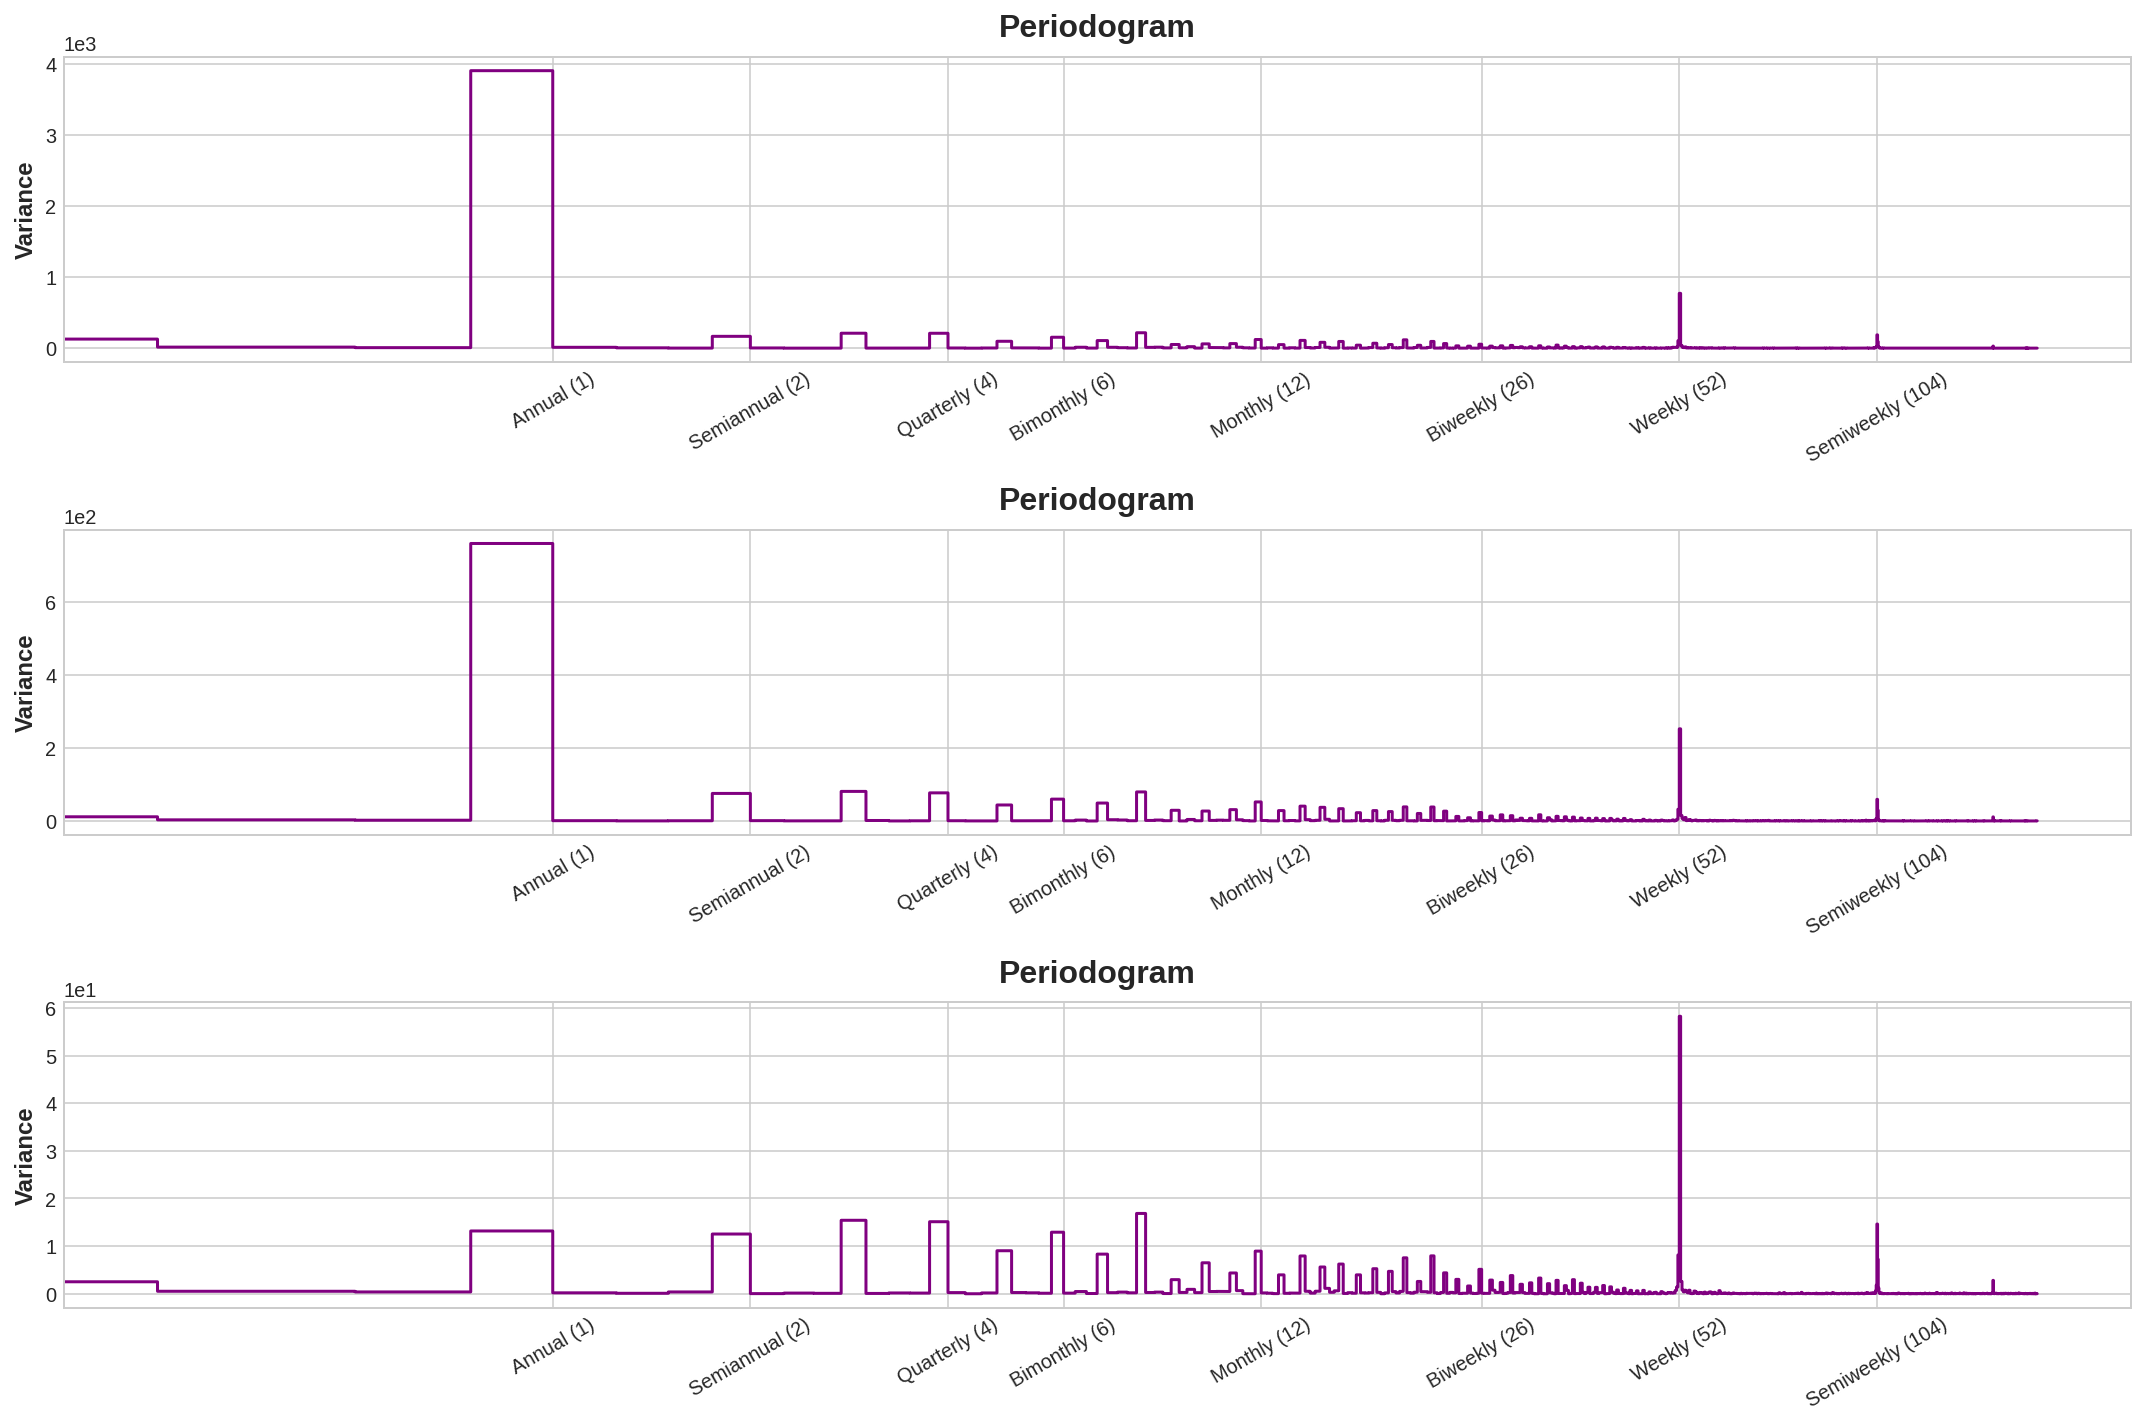

In [50]:
# Checks for strength of frequency in the time series

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15,10))
plot_periodogram(train.loc[('Finland', 'KaggleMart', 'Kaggle Hat')].num_sold, ax=axs[0])
plot_periodogram(train.loc[('Finland', 'KaggleMart', 'Kaggle Mug')].num_sold, ax=axs[1])
plot_periodogram(train.loc[('Finland', 'KaggleMart', 'Kaggle Sticker')].num_sold, ax=axs[2])

The first two periodograms above show strong _Annual (1)_ with moderate _weekly (52)_  seasonality for both product Kaggle Hat and Kaggle Mug. The third periodogram shows high weekly seasonality for product Kaggle Sticker.

# Modeling & Evaluation

## Statistical Modeling

In [106]:
# Unstack train data till 2017 (leaving 2018 to be used as validation data)
y_train = train.unstack(["country", "store", "product"])[:'2017']

In [165]:
# Creates Fourier series as deterministic terms
fourier = CalendarFourier(freq='A', order=10)

# Creates container for deterministic terms created above
dp = DeterministicProcess(
    index=y_train.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

# Creates features from deterministic terms and adds seasonal indicators
X_train = dp.in_sample()
X_train['Week'] = X_train.index.week
X_train['Day'] = X_train.index.dayofweek
X_train['NewYearDay'] = X_train.index.dayofyear.map(lambda x: 1 if x==1 else 0)
# 'GoodFriday'?
# 'Chirstmas day and Christmas eve'?
# 'Year end'?

In [167]:
# Trains a linear regression model

model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Checks for train performance
y_train_pred = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y_train.columns)
print(f"Train performance (MAPE): {mape(y_train, y_train_pred)}")

Train performance (MAPE): 0.072029876793762


In [168]:
# Creates features and targets for validation data

X_val = dp.out_of_sample(steps=365)
X_val['Week'] = X_val.index.week
X_val['Day'] = X_val.index.dayofweek
X_val['NewYearDay'] = X_val.index.dayofyear.map(lambda x: 1 if x==1 else 0)
# 'GoodFriday'?
# 'Chirstmas day and Christmas eve'?
# 'Year end'?

y_val = train.unstack(["country", "store", "product"]).loc['2018']

In [169]:
# Checks validation perfomance
y_val_pred = pd.DataFrame(model.predict(X_val), index=X_val.index, columns=y_val.columns)
print(f"Validation performance (MAPE): {mape(y_val, y_val_pred)}")

Validation performance (MAPE): 0.07930374693404357


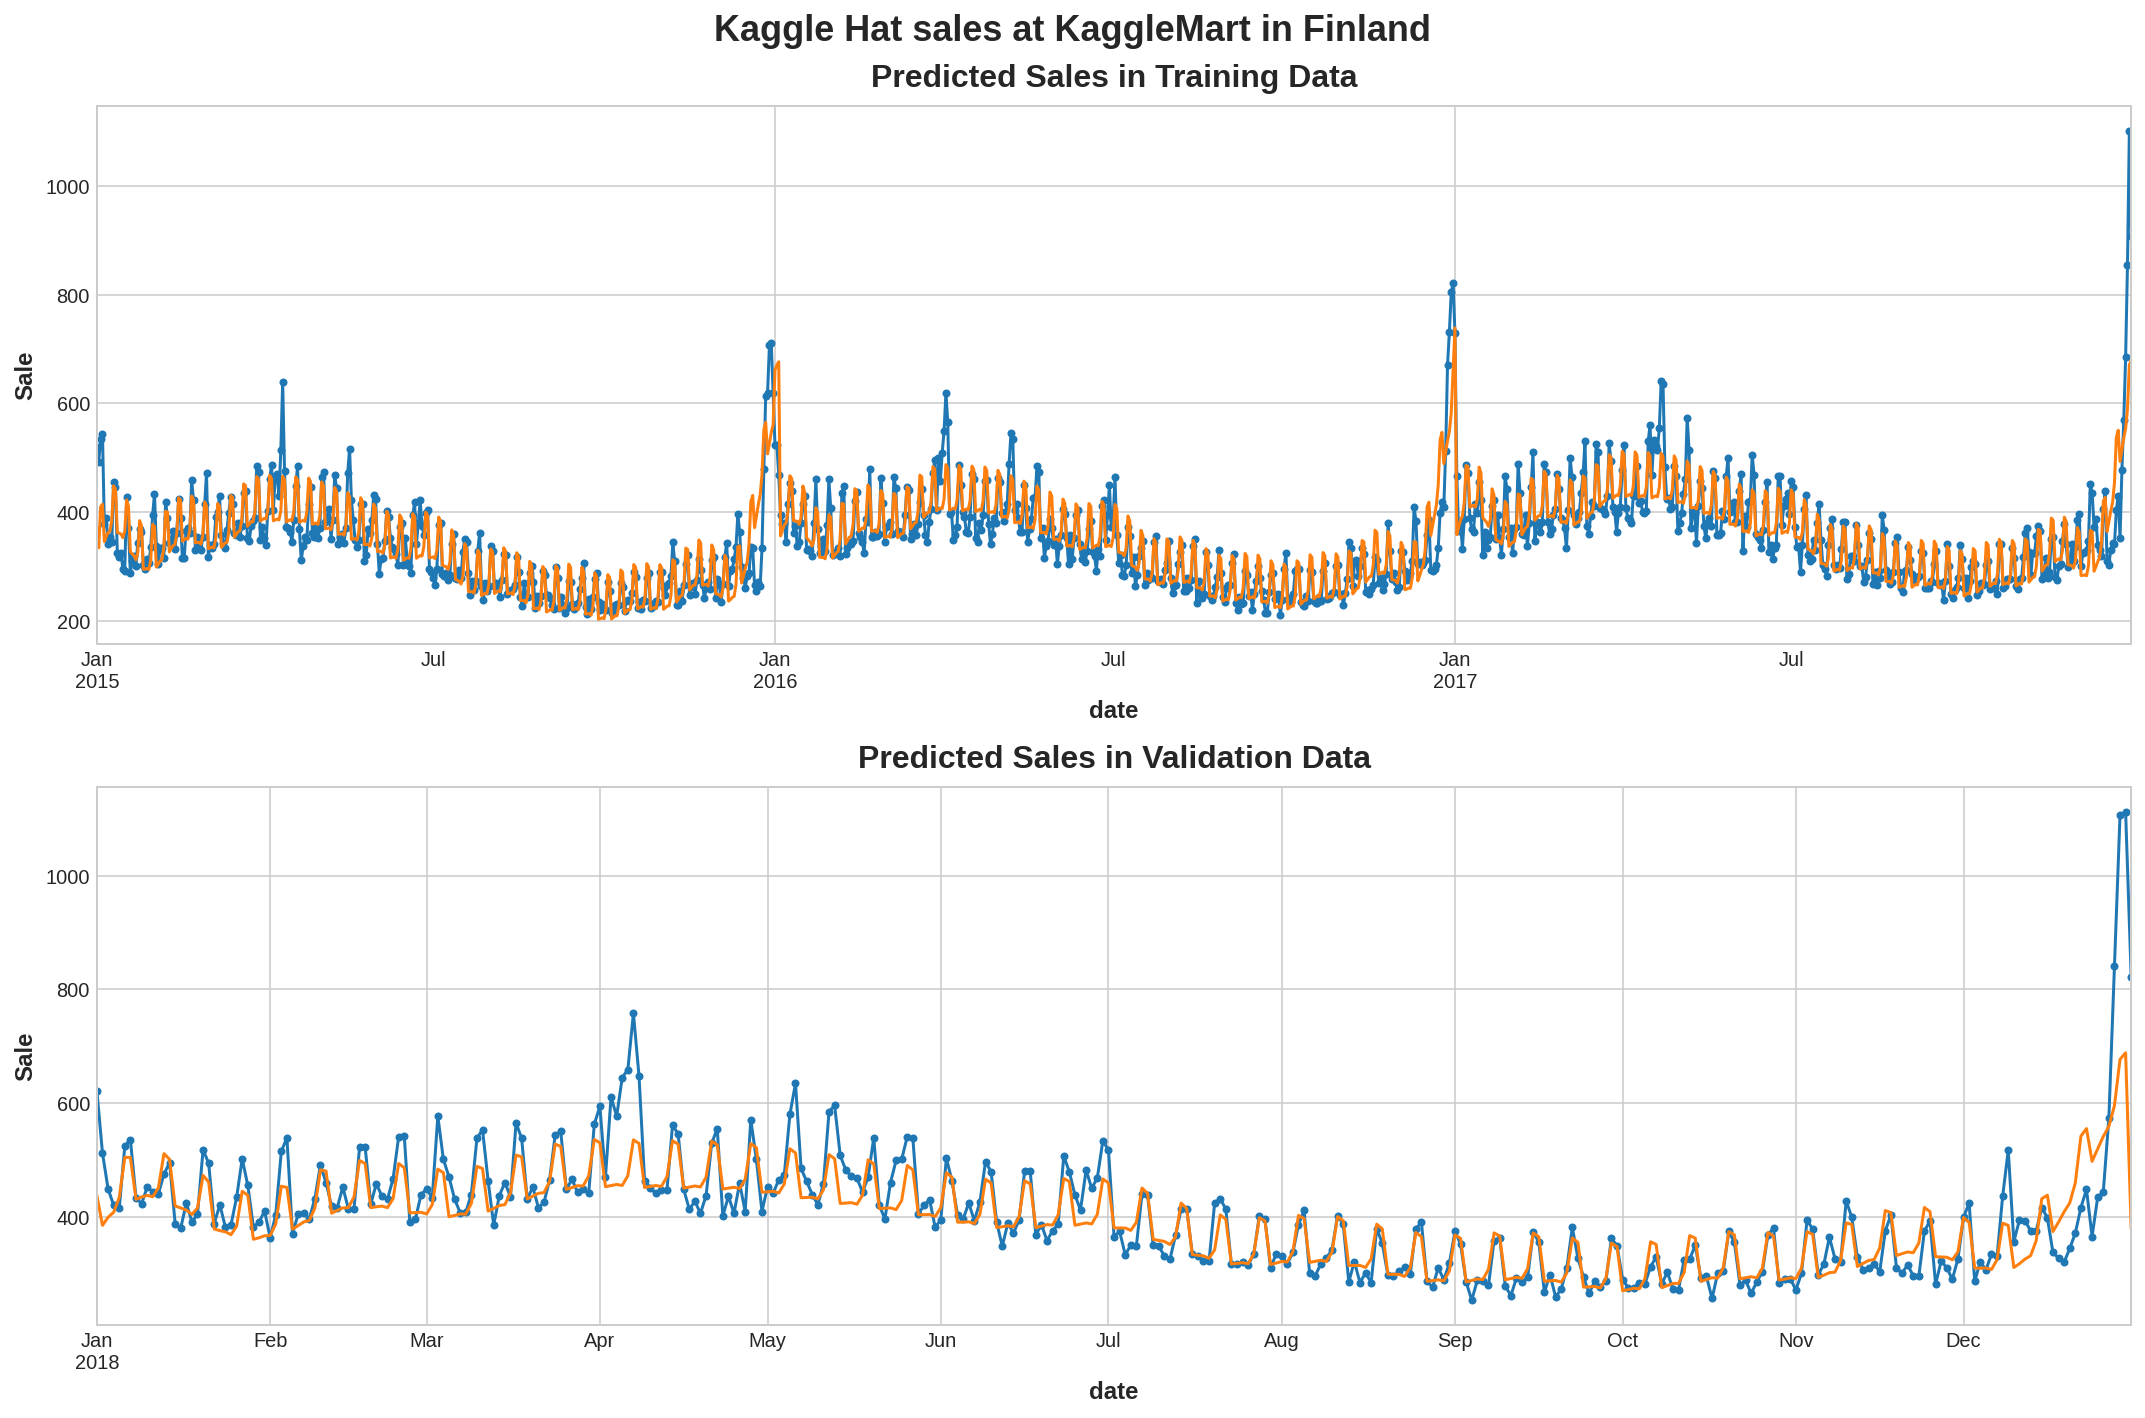

In [170]:
# Visualize how prediction performs on training and validation data

COUNTRY = 'Finland'
STORE = 'KaggleMart'
PRODUCT = 'Kaggle Hat'

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,10))

y_train.loc(axis=1)['num_sold', COUNTRY, STORE, PRODUCT].plot(
    style=".-", ax=axs[0], ylabel="Sale", title="Predicted Sales in Training Data")
y_train_pred.loc(axis=1)['num_sold', COUNTRY, STORE, PRODUCT].plot(ylabel="Sale", ax=axs[0])

y_val.loc(axis=1)['num_sold', COUNTRY, STORE, PRODUCT].plot(
    style=".-", ax=axs[1], title="Predicted Sales in Validation Data")
y_val_pred.loc(axis=1)['num_sold', COUNTRY, STORE, PRODUCT].plot(ylabel="Sale", ax=axs[1])

fig.suptitle(f'{PRODUCT} sales at {STORE} in {COUNTRY}');

# Submission

In [171]:
# Unstack full train data (including for 2018)
y_train = train.unstack(["country", "store", "product"])

In [172]:
# Creates container for deterministic terms created above
dp = DeterministicProcess(
    index=y_train.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

# Creates features from deterministic terms and adds seasonal indicators
X_train = dp.in_sample()
X_train['Week'] = X_train.index.week
X_train['Day'] = X_train.index.dayofweek
X_train['NewYearDay'] = X_train.index.dayofyear.map(lambda x: 1 if x==1 else 0)
# 'GoodFriday'?
# 'Chirstmas day and Christmas eve'?
# 'Year end'?

In [174]:
# Trains a linear regression model

model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Checks for train performance
y_train_pred = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y_train.columns)
print(f"Train performance (MAPE): {mape(y_train, y_train_pred)}")

Train performance (MAPE): 0.0739715630261548


In [175]:
# Creates features and targets for test data

X_test = dp.out_of_sample(steps=365)
X_test['Week'] = X_test.index.week
X_test['Day'] = X_test.index.dayofweek
X_test['NewYearDay'] = X_test.index.dayofyear.map(lambda x: 1 if x==1 else 0)
# 'GoodFriday'?
# 'Chirstmas day and Christmas eve'?
# 'Year end'?

In [176]:
# Predicts on test data
y_test = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y_train.columns)

In [178]:
# Sets name to its index
y_test.index.name = "date"

# Stacks columns
y_test = y_test.stack(["country", "store", "product"])

In [182]:
# Checks how the predictions looks
display(y_test)

num_sold
date       country store      product                   
2019-01-01 Finland KaggleMart Kaggle Hat      526.575014
                              Kaggle Mug      329.537596
                              Kaggle Sticker  142.770632
                   KaggleRama Kaggle Hat      888.208995
                              Kaggle Mug      567.804950
...                                                  ...
2019-12-31 Sweden  KaggleMart Kaggle Mug      305.444317
                              Kaggle Sticker  136.745277
                   KaggleRama Kaggle Hat      847.253444
                              Kaggle Mug      538.496208
                              Kaggle Sticker  236.052207

[6570 rows x 1 columns]

In [208]:
# Loads test data
test = pd.read_csv("./data/test.csv", parse_dates=["date"], infer_datetime_format=True)

# Converts 'date' column to period with 'day' frequency
test.date = test.date.dt.to_period("D")

# Reindexes test data set with sorting
test = test.set_index(["date", "country", "store", "product"])

In [211]:
# Joins the test and prediction dataset to map predictions in order mentioned in test dataset
test = test.join(y_test, on=["date", "country", "store", "product"], how="inner")

# Sets new index
test = test.set_index(["row_id"])

In [213]:
# Saves predictions into file for submission
test.to_csv("submission.csv")

_**Leaderboard score against this submission was 11.45279 (SMAPE) and highest score as on Dec. 24, 2022 was 3.99775**_